In [1]:
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
LIMIT = 250

In [3]:
bitcoin_address =  pd.read_csv('bitcoin_address.csv',nrows=LIMIT)

bitcoin_address_link =  pd.read_csv('bitcoin_address_link.csv',nrows=LIMIT)

domain =  pd.read_csv('domain.csv',nrows=LIMIT)

email =  pd.read_csv('email.csv',nrows=LIMIT)

email_link =  pd.read_csv('email_link.csv',nrows=LIMIT)

page =  pd.read_csv('page.csv',nrows=LIMIT)

page_link =  pd.read_csv('page_link.csv',nrows=LIMIT)

In [4]:
import networkx as nx

G = nx.Graph()

In [5]:
bitcoin_address.head(1)

Unnamed: 0     id                            address
0           0  93621  1111AjKts3rxSrWNUZAS76zrY8ENsG59q

In [6]:
#insert bitcoin address nodes

for index, row in tqdm(bitcoin_address.iterrows()):
    G.add_node('b{}'.format(row.id), label='b')

In [7]:
page.head(1)

Unnamed: 0        id                             url  \
0           0  14817765  http://vfgop7uag7dpxuxq.onion/   

                          title  code  domain           created_at  \
0  The Pot Shop – Best Pot Ever   504  304845  2020-04-17 07:43:31   

            visited_at  is_frontpage  size path  
0  2020-06-22 04:24:01             1    93    /

In [8]:
#insert pages

for index, row in tqdm(page.iterrows()):
    G.add_node('p{}'.format(row.id), label='p')

In [9]:
domain.head(1)

Unnamed: 0      id                    host  port  ssl  is_up  \
0           0  304845  vfgop7uag7dpxuxq.onion    80    0      0   

            created_at           visited_at                         title  \
0  2020-04-17 07:43:31  2020-06-22 04:24:01  The Pot Shop – Best Pot Ever   

            last_alive  ...  useful_404_php  useful_404_dir  clone_group  \
0  2020-06-02 06:50:56  ...               1               0          NaN   

   new_clone_group  ban_exempt manual_genuine language  description_json  \
0              NaN           0              0      NaN               NaN   

   description_json_at           whatweb_at  
0  2020-05-28 01:50:52  1970-01-01 00:00:00  

[1 rows x 34 columns]

In [10]:
#insert domain

for index, row in tqdm(domain.iterrows()):
    G.add_node('d{}'.format(row.id), label='d')

In [11]:
email.head(1)

Unnamed: 0      id                                            address
0           0  130119  +-gpuepfqorbywdwm-eo4egbrcnttxovs4a@mail.gmail...

In [12]:
#insert emails

for index, row in tqdm(email.iterrows()):
    G.add_node('e{}'.format(row.id), label='e')

In [13]:
#insert page - bitcoin addres edges

for index, row in tqdm(bitcoin_address_link.iterrows()):
    G.add_edge('b{}'.format(row.bitcoin_address), 'p{}'.format(row.page), label='p2b' )

In [14]:
#insert page - domain edges

for index, row in tqdm(page.iterrows()):
    G.add_edge('p{}'.format(row.id), 'd{}'.format(row.domain), label='p2d' )

In [15]:
#insert page - email address edges

for index, row in tqdm(email_link.iterrows()):
    G.add_edge('e{}'.format(row.email), 'p{}'.format(row.page), label='e2p' )

In [16]:
#insert page - page edges

for index, row in tqdm(page_link.iterrows()):
    G.add_edge('p{}'.format(row.link_from), 'p{}'.format(row.link_to), label='p2p' )

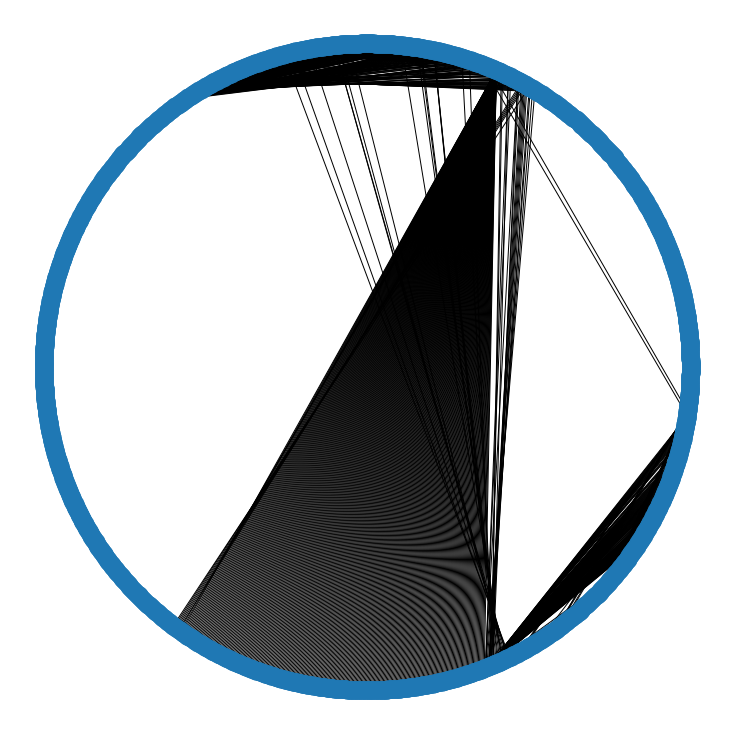

In [17]:
import scipy
from matplotlib import pyplot as plt
plt.figure(3,figsize=(10,10)) 
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=not True)
plt.show()

In [18]:
#maximum digree
print(max(dict(G.degree()).items(), key = lambda x : x[1]))
#minium digree
print(min(dict(G.degree()).items(), key = lambda x : x[1]))

('p14817800', 246)
('b93621', 0)


In [19]:
import stellargraph as sg
from stellargraph import StellarGraph

In [20]:
square = StellarGraph.from_networkx(G)

In [21]:
print(square.info())

StellarGraph: Undirected multigraph
 Nodes: 1544, Edges: 983

 Node types:
  default: [544]
    Features: none
    Edge types: default-e2p->default, default-e2p->p, default-p2b->p, default-p2p->default, default-p2p->p
  p: [250]
    Features: none
    Edge types: p-e2p->default, p-p2b->default, p-p2d->d, p-p2p->default, p-p2p->p
  e: [250]
    Features: none
    Edge types: none
  d: [250]
    Features: none
    Edge types: d-p2d->p
  b: [250]
    Features: none
    Edge types: none

 Edge types:
    default-p2b->p: [250]
        Weights: all 1 (default)
        Features: none
    d-p2d->p: [250]
        Weights: all 1 (default)
        Features: none
    default-e2p->default: [216]
        Weights: all 1 (default)
        Features: none
    p-p2p->p: [177]
        Weights: all 1 (default)
        Features: none
    default-p2p->default: [54]
        Weights: all 1 (default)
        Features: none
    default-e2p->p: [34]
        Weights: all 1 (default)
        Features: none
    defa

In [22]:
nx.number_connected_components(G)

743

In [23]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [24]:
Gcc = sorted(connected_component_subgraphs(G), key=len, reverse=True)
cc_sizes = []
for cc in list(Gcc):
    cc_sizes.append(len(cc.nodes()))
print(cc_sizes[:10])

[336, 255, 147, 9, 7, 7, 5, 4, 4, 3]


In [25]:
import igraph as ig
# translate the object into igraph
g_ig = ig.Graph.Adjacency((nx.to_numpy_matrix(G) > 0).tolist(), mode=ig.ADJ_UNDIRECTED)
g_ig.summary()

'IGRAPH U--- 1544 983 -- '

In [26]:
import random
# perform community detection
random.seed(123)
c_infomap = g_ig.community_infomap()
print(c_infomap.summary())

Clustering with 1544 elements and 782 clusters


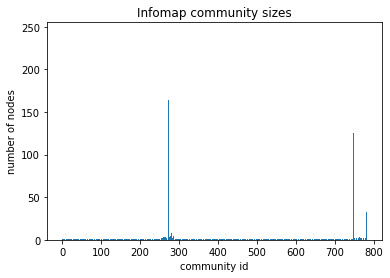

In [27]:
from matplotlib import pyplot as plt
# plot the community sizes
infomap_sizes = c_infomap.sizes()
plt.title("Infomap community sizes")
plt.xlabel("community id")
plt.ylabel("number of nodes")
plt.bar(list(range(1, len(infomap_sizes) + 1)), infomap_sizes)
plt.show()

In [28]:
# Modularity metric for infomap
c_infomap.modularity

0.7529672799752477

In [29]:
# assign community membership results back to networkx, keep the dictionary for later comparisons with the clustering
infomap_com_dict = dict(zip(list(G.nodes()), c_infomap.membership))
nx.set_node_attributes(G, infomap_com_dict, "c_infomap")

In [30]:
com_id = max(c_infomap.sizes())  # smaller number - larger community, as it's sorted

In [31]:
com_id = 270

In [32]:
# extraction of a subgraph from the nodes in this community
com_G = G.subgraph([n for n, attrdict in G.nodes.items() if attrdict["c_infomap"] == com_id])
print(nx.info(com_G))

Name: 
Type: Graph
Number of nodes: 9
Number of edges: 17
Average degree:   3.7778


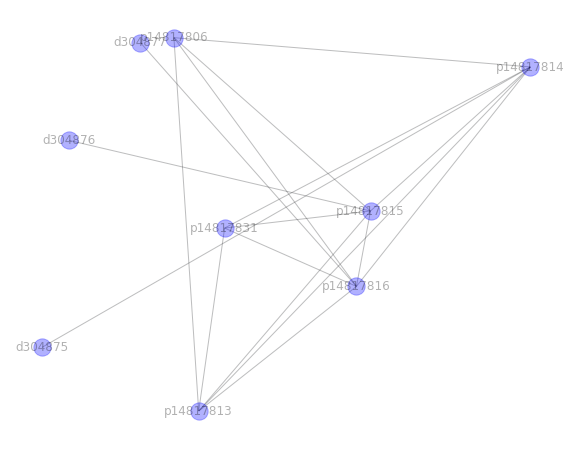

In [33]:
# plot community structure only
pos = nx.random_layout(com_G, seed=123)
plt.figure(figsize=(10, 8))
nx.draw_networkx(com_G, pos, edge_color="#26282b", node_color="blue", alpha=0.3)
plt.axis("off")
plt.show()